# Simple CNN model for image classification

This notebook contains a simple CNN model to classify between faulty and normal transformers using their thermal images.

In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
from helpers import view_misclassified_images_cnn
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
data_dir = "separated_data"
batch_size = 16
image_size = (256, 256)
num_epochs = 100

In [4]:
class PathImageFolder(torchvision.datasets.ImageFolder):
    """ImageFolder that also returns the file path with each sample."""
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target, path

In [5]:
full_Dataset = PathImageFolder(
    root=data_dir,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_size),
        torchvision.transforms.ToTensor(),
    ])
)

class_names = full_Dataset.classes

train_size = int(0.8 * len(full_Dataset))
val_size = len(full_Dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_Dataset, [train_size, val_size])

In [6]:
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 84
Validation samples: 21


In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Obtain an EfficientNet-B7 model pre-trained on ImageNet and fine-tune it on the transformer dataset.

In [8]:
model = torchvision.models.efficientnet_b7(weights='DEFAULT').to(device)
print(summary(model, input_size=(batch_size, 3, *image_size), col_names=["input_size", "output_size", "num_params", "trainable"]))

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [16, 3, 256, 256]         [16, 1000]                --                        True
├─Sequential: 1-1                                       [16, 3, 256, 256]         [16, 2560, 8, 8]          --                        True
│    └─Conv2dNormActivation: 2-1                        [16, 3, 256, 256]         [16, 64, 128, 128]        --                        True
│    │    └─Conv2d: 3-1                                 [16, 3, 256, 256]         [16, 64, 128, 128]        1,728                     True
│    │    └─BatchNorm2d: 3-2                            [16, 64, 128, 128]        [16, 64, 128, 128]        128                       True
│    │    └─SiLU: 3-3                                   [16, 64, 128, 128]        [16, 64, 128, 128]        --                        --
│    └─Sequential: 2-2  

Change the classifier layer to match the number of classes in the dataset.

In [9]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(model.classifier[1].in_features, len(class_names))
).to(device)
print(summary(model, input_size=(batch_size, 3, *image_size), col_names=["input_size", "output_size", "num_params", "trainable"]))

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [16, 3, 256, 256]         [16, 2]                   --                        True
├─Sequential: 1-1                                       [16, 3, 256, 256]         [16, 2560, 8, 8]          --                        True
│    └─Conv2dNormActivation: 2-1                        [16, 3, 256, 256]         [16, 64, 128, 128]        --                        True
│    │    └─Conv2d: 3-1                                 [16, 3, 256, 256]         [16, 64, 128, 128]        1,728                     True
│    │    └─BatchNorm2d: 3-2                            [16, 64, 128, 128]        [16, 64, 128, 128]        128                       True
│    │    └─SiLU: 3-3                                   [16, 64, 128, 128]        [16, 64, 128, 128]        --                        --
│    └─Sequential: 2-2  

Set only the classifier layer to be trainable, freezing the rest of the model.

In [10]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

print(summary(model, input_size=(batch_size, 3, *image_size), col_names=["input_size", "output_size", "num_params", "trainable"]))

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [16, 3, 256, 256]         [16, 2]                   --                        Partial
├─Sequential: 1-1                                       [16, 3, 256, 256]         [16, 2560, 8, 8]          --                        False
│    └─Conv2dNormActivation: 2-1                        [16, 3, 256, 256]         [16, 64, 128, 128]        --                        False
│    │    └─Conv2d: 3-1                                 [16, 3, 256, 256]         [16, 64, 128, 128]        (1,728)                   False
│    │    └─BatchNorm2d: 3-2                            [16, 64, 128, 128]        [16, 64, 128, 128]        (128)                     False
│    │    └─SiLU: 3-3                                   [16, 64, 128, 128]        [16, 64, 128, 128]        --                        --
│    └─Sequential

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [12]:
misclassified_images = []
misclassified_paths = []

In [13]:
max_accuracy = 0.0
os.makedirs('models', exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        if isinstance(batch, (list, tuple)) and len(batch) == 3:
            images, labels, _paths = batch
        else:
            images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    model.eval()
    correct = 0
    total = 0
    with torch.inference_mode():
        for batch in val_loader:
            if isinstance(batch, (list, tuple)) and len(batch) == 3:
                images, labels, paths = batch
            else:
                images, labels = batch
                paths = [None] * images.size(0)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            mis_mask = (predicted != labels)
            if (epoch == num_epochs - 1):
                if mis_mask.any().item():
                    idx_list = mis_mask.nonzero(as_tuple=False).squeeze(1).cpu().tolist()
                    for i in idx_list:
                        misclassified_images.append(images[i].detach().cpu())
                        if paths and paths[0] is not None:
                            misclassified_paths.append(paths[i])

    accuracy = 100 * correct / total
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        torch.save(model.state_dict(), 'models/best_model.pth')

    if (epoch+1) % 10 == 0 or epoch == num_epochs - 1:
        print("=====================================================")
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")
        print(f'Validation Accuracy: {accuracy:.2f}%')

Epoch [10/100], Training Loss: 0.5769
Validation Accuracy: 66.67%
Epoch [20/100], Training Loss: 0.5299
Validation Accuracy: 61.90%
Epoch [30/100], Training Loss: 0.4672
Validation Accuracy: 66.67%
Epoch [40/100], Training Loss: 0.4103
Validation Accuracy: 71.43%
Epoch [50/100], Training Loss: 0.4042
Validation Accuracy: 71.43%
Epoch [60/100], Training Loss: 0.3449
Validation Accuracy: 71.43%
Epoch [70/100], Training Loss: 0.3372
Validation Accuracy: 71.43%
Epoch [80/100], Training Loss: 0.3382
Validation Accuracy: 71.43%
Epoch [90/100], Training Loss: 0.2866
Validation Accuracy: 76.19%
Epoch [100/100], Training Loss: 0.3157
Validation Accuracy: 76.19%


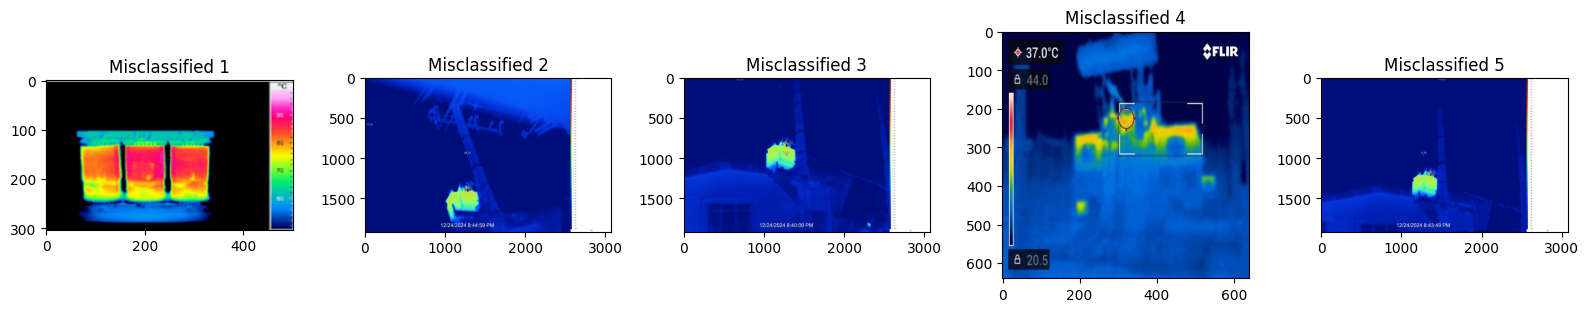

In [14]:
view_misclassified_images_cnn(misclassified_paths = misclassified_paths, max_images=20, cols=5)